# Source Panel Methods

Reviewing what we know: 
- The superposition powers
- The superposition of a  doublet and freestream -flow around a cylinder
- D'Alembert paradox: the result of zero drag for potential flow around a cylinder
- Kutta-Joukowski Theorem- lift is proportional to circulation 

**Lesson 09**- direct method -- stipulate the geometry and then solve the source strengths on a panel discretization of the body that makes the flow tangent at the boundary

A set of panels (line segments in 2D) can be used to represent the surface of any solid body immersed in a potential flow by making the source-sheet strengths such that the normal velocity at each panel is zero. 

For an arbitrary geometry, we need to build a set of panels according to some points that define geometry 

We will read in a file from geometry definition corresponding to **NACA0012 airfoil**, create a set of the panels, and solve for the source-sheet strengths to get flow around the airfoil 

Load our favorite Python Libraries and the inegrate module from SciPy

In [1]:
import os 
import math 
import numpy
from scipy import integrate
from matplotlib import pyplot 
# display the figures in the Notebook 
%matplotlib inline 

We want to read in the body geometry from a file using the NumPy function **loadtxt()**. The file comes from the Airfoil Tools website and it contains a set of coordinates from the standard NACA0012 symmetric profile. we saved the file in the resources folder and load it from our local copy. 

The geometry points get loaded into one Numpy array so we separate the data into two arrays: x,y (for better code readability). The subsequent code will plot the geometry of the airfoil. 

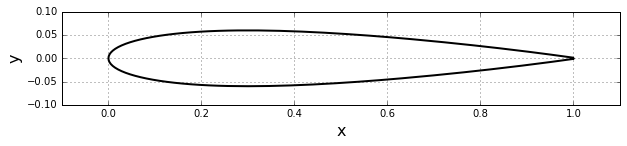

In [2]:
# read of the geometry from a data file
naca_filepath = os.path.join( 'naca0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = numpy.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plot the geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

## Discretization into panels 

We are going to discritize the body geometry into panels (line segments in 2D)

Panel attributes:
 - Starting Point 
 - End Point 
 - Mid-point 
 - Length 
 - Orientation 
 
We can modify from our class **Panel** from our previous noteboook for the airfoil geometry. 

The only difference is we need to identify points on the top or bottom surfaces with the words *upper* and *lower* 
    - these will be used only for plotting results with different colors for top and bottom surfaces of the profile 
    
    

In [3]:
class Panel: 
    """ 
    Contains info related to a panel. 
    """
    def __init__(self,xa,ya,xb,yb):
        """ 
        Initializes the panel. 
        
        Sets the end-points and calculates the center, length, and 
        angle (with the x-axis) of the panel. 
        Defines if the panel is on the lowe or upper surface of the geometry. 
        Initializes the source-sheet strength, tangential velocity, 
        and pressure coefficient to zero. 
        
        Parameters
        ----------
        xa: float 
            x-coordinate of the first endpoint. 
        ya: float 
            y-coordinate of the first endpoint. 
        xb: float 
            x-coordinate of the second end-point. 
        yb: float 
            y-coordinate of the second end-point. 
        """
        self.xa, self.ya = xa, ya 
        self.xb, self.yb = xb, yb 
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2 # center points 
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2) #length of the panel 
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0. : 
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa >= 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        # location of the panel 
        if self.beta <= math.pi: 
            self.loc = 'upper'
        else: 
            self.loc = 'lower'
            
        self.sigma = 0. # source strength 
        self.vt = 0. # tangential velocity 
        self.cp = 0. #pressure coefficient 

Defining the geometry of the circular cylinder was really wasy. This is the more complicated part.

We are going to create a code that will create panels from the geometry data. It is better to have small panels near the leading-edge and the trailing edge where the curvature is large. One methods to get a non-uniform distribution around the airfoil is to first discretize a circle with diameter equal to the airfoil's chord and discretize. Those x-coordinates on the circle will also be the x-coordinates of the panel nodes. We will project the y-coordinates on the airfoil by interpolation. 


Notes on **define_panels()**: 
    - we just need to compute the x-coordinates of the circle since the y-coordinates of the panel nodes will computed by interpolation 
    - we create a circle with N+1 points but the first and last points coincide 
    - we extend our NumPy arrays by adding an extra value that is equal to the first one; thus we don't have to do anything special with the value x[i+1] in the different loops; 
    - the while-loop is used to fine two consecutive points (x[I}, y[I]) and (x[ i+1], y[i+1]) on the foil such that the interval (x[I], x[I+1]) contrains the value of x_ends[i]; we use the keyword break to get out fo the loop. 
    - once the two points have been identified, the value y_ends[i] is computed by interpolation 
    

In [4]:
def define_panels(x, y, N=40): 
    """
    Discretizes the geometry into panels using the 'cosine' method. 
    
    Parameters
    ----------
    x: 1D array of floats 
        x-coordinate of the points defining the geometry. 
    y: 1D array of floats 
        y-coordinate of the points defining the geometry. 
    N: ineteger, optional 
        Number of panels; 
        default: 40. 
        
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels. 
    """
    
    R = (x.max()-x.min())/2  # radius of the circle 
    x_center = (x.max()+x.min())/2 
    x_circle = x_center + R*numpy.cos(numpy.linspace(0,2*math.pi, N+1)) 
    
    x_ends = numpy.copy(x_circle) #projection of the x-coordinates on surface 
    y_ends = numpy.empty_like(x_ends) # initialization of the y-coord Numpy array
    
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0]) #extend arrays using numpy. append
    
    #computes the y-coordinates of the end-points 
    I = 0 
    for i in range(N):
        while I < len(x)-1: 
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1]- a*x[I+1]
        y_ends[i]= a*x_ends[i]+ b
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

Now we can use this function, calling it with the desired number of panels whenever we execute the cell below. We also plot the resulting geometry 

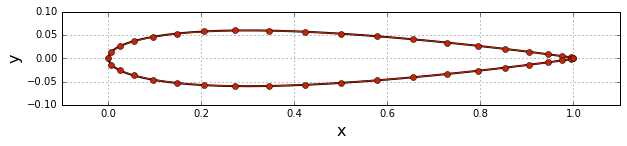

In [7]:
N= 40  #number of panels 
panels = define_panels(x,y, N) #discretizes the geometry 

# plot the geometry and the panels 
width = 10 
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x,y,color = 'k', linestyle = '-', linewidth =2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa), 
            numpy.append([panel.ya for panel in panels], panels[0].ya), 
            linestyle = '-', linewidth =1, marker = 'o', markersize = 6, 
            color = '#CD2305')
pyplot.axis('scaled', adjutable= 'box')
pyplot.xlim(-0.1, 1.1 )
pyplot.ylim(-0.1, 0.1);

## Freestream conditions 

The airfoil will be immersed in a uniform flow with the velocity u-inf at an angle of attack alpha = 0 

We will create the freestream class for improved readability 


In [8]:
class Freestream: 
    """
    Freestream conditions. 
    """
    
    def __init__(self, u_inf= 1.0, alpha = 0.0):  
        """
        Sets the freestream speed and angle (with the x-axis)
        
        Parameters
        -----------
        u_inf: float, optional 
            Freestream speed; 
            default = 1.0 
        alpha: float, optional 
            Angle of attack in degrees; 
            default = 0.0. 
        """
        
        self.u_inf = u_inf 
        self.alpha = alpha*math.pi/180 
        #returns in radians 

In [9]:
# define and creates the object freestream 
u_inf = 1.0 
alpha = 0.0 
freestream  = Freestream(u_inf, alpha) 


## Flow tangency boundary conditions 

Enforcing the flow-tangency conditions on each *control-point* approximately makes the body geometry correspond to a dividing streamline (and the approximation improves if we represented the bosy with more and more panels) So for each panel i, we make un = 0 at xc, yc which leads equations similar to ones implemented in Lesson09 

In [17]:
def integral(x, y, panel, dxdz, dydz): 
    """
    Evaluates the contribution of a panel at one point. 
    
    Parameters
    ----------
    x: float 
        x-coordinate of the target point. 
    y: float 
        y-coordinate of the target point. 
    panel: Panel object 
        Source panel which contribution is evaluated. 
    dxdz: float 
        Derivative of x in the z-direction. 
    dydz: float 
        Derivative of y in the z-direction. 
    
    Returns
    -------
    Integral over the panel of the influence at the given target point. 
    """
    
    def integrand(s): 
        return ( ((x-(panel.xa - math.sin(panel.beta)*s))*dxdz
                 +(y - (panel.ya + math.cos(panel.beta)*s))*dydz)
               / ((x - (panel.xa - math.sin(panel.beta)*s))**2
                 +(y- (panel.ya +math.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

## Building the linear system 

We are going to solve 
Ax = b 
where x is the source strengths and use linalg.solve() from NumPy to solve the system and find the strength of each panel. 

In [18]:
def build_matrix(panels):
    """
    Builds the source matrix. 
    
    Parameters
    ----------
    panels: 1D array of Panel object
        The source panels.
    
    Returns 
    --------
    A: 2D Numpy array of floats 
        The source matrix (NxN matric, N is the number of panels). 
    """
    N = len(panels)
    A = numpy.empty((N,N), dtype = float) 
    numpy.fill_diagonal(A, 0.5) 
    
    for i, p_i in enumerate(panels): 
        for j, p_j in enumerate(panels): 
            if i != j: 
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, math.cos(p_i.beta), math.sin(p_i.beta))
                
    return A

def build_rhs(panels,freestream): 
    """
    Builds the RHS of the linear system. 
    
    Parameters
    ----------
    panels: 1D array of Panel objects 
        The source panels 
    freestream: Freestream object 
        The freestream conditions. 
    
    Returns
    -------
    b: 1D Numpy array of floats 
        RHS of the linear system. 
    """
    
    b= numpy.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels): 
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    return b

In [19]:
A = build_matrix(panels)
b = build_rhs(panels, freestream)

In [20]:
# solve the linear system 
sigma = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels): 
    panel.sigma = sigma[i]

## Surface Pressure coefficient 

equations! 

In [26]:
def get_tangential_velocity(panels, freestream): 
    """
    Computes the tangential velocity of the surface of the panels. 
    
    Parameters
    -----------
    panels: 1D array of Panel objects 
        The source panels. 
    freestream: Freestream object
        The freestream conditions. 
    """
    
    N = len(panels) 
    A = numpy.empty((N,N), dtype = float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels): 
        for j, p_j in enumerate(panels): 
            if i != j:
                A[i,j] = 0.5/math.pi*integral(p_i.xc, p_i.yc, p_j, -math.sin(p_i.beta), math.cos(p_i.beta))
            
    b = freestream.u_inf * numpy.sin([freestream.alpha- panel.beta for panel in panels])
    
    sigma = numpy.array([panel.sigma for panel in panels])
    
    vt =numpy.dot(A, sigma) + b 
    
    for i, panel in enumerate(panels): 
        panel.vt = vt[i]

In [27]:
# compute the tangential velocity at the center-point of each panel 
get_tangential_velocity(panels,freestream)

In [29]:
def get_pressure_coefficient(panels, freestream):
    """ 
    Computes the surface pressure coefficient on the panels. 
    
    Parameters
    ----------
    panels: 1D array of Panel objects 
        The source panels. 
    Freestream: Freestream object
        The freestream conditions. 
    """
    for panel in panels: 
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [30]:
# Computes the surface pressure coefficient 
get_pressure_coefficient(panels, freestream)


### Theoretical solution

Theodorsen's method: a classical method to obtain the theoretical characterisitics of airfoils, uses the Joukowski transformation but is able to deal with any airfoil by an addition transformation between a "near circle" and a circle. 


The values of (u/u_inf0^2 are given for several stations along the chord length. We have transcribed them here....

In [33]:
voverVsquared = numpy.array([0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411, 
                            1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 
                            0.956, 0.906, 0.])
print(voverVsquared)

[ 0.     0.64   1.01   1.241  1.378  1.402  1.411  1.411  1.399  1.378
  1.35   1.288  1.228  1.166  1.109  1.044  0.956  0.906  0.   ]


In [35]:
xtheo=numpy.array([0, 0.5, 1.25, 2.5, 5.0, 7.5, 10, 15, 
                   20, 25, 30, 40, 50, 60, 70, 80, 90, 95, 100])
xtheo = xtheo/100
print(xtheo)

[ 0.      0.005   0.0125  0.025   0.05    0.075   0.1     0.15    0.2     0.25
  0.3     0.4     0.5     0.6     0.7     0.8     0.9     0.95    1.    ]


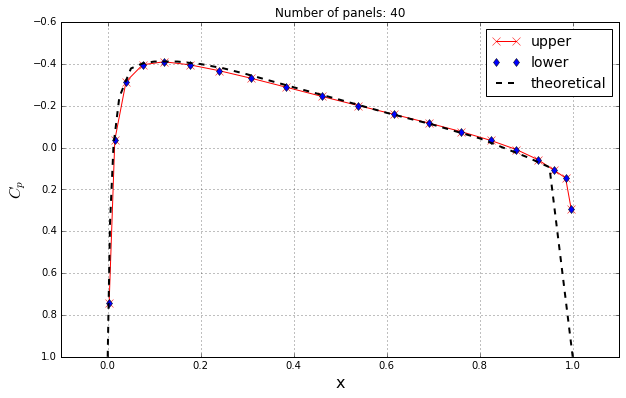

In [37]:
# plot the surface pressure coefficient 
pyplot.figure(figsize=(10,6))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize =16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
           [panel.cp for panel in panels if panel.loc =='upper'],
           label ='upper', 
           color= 'r', linewidth=1, marker='x', markersize =8)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'], 
           label = 'lower', 
           color = 'b', linewidth = 0, marker = 'd', markersize=6)
pyplot.plot(xtheo, 1-voverVsquared, 
           label = 'theoretical', color ='k', linestyle='--', linewidth = 2)
pyplot.legend(loc ='best', prop={'size': 14})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -0.6)
pyplot.title('Number of panels: %d' %N);

In [38]:
# accuracy check 
accuracy = sum([panel.sigma*panel.length for panel in panels])
print('--> sum of source/sink strengths: {}' .format(accuracy))

--> sum of source/sink strengths: 0.00461703117528311
